In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt 
import scipy
import sys

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sys.path.append(os.path.abspath('..'))
from xenium_cluster import XeniumCluster

In [2]:
grid_size = 50
num_clusters = 7
data_dimension = 5
random_seed = 1
r = 1

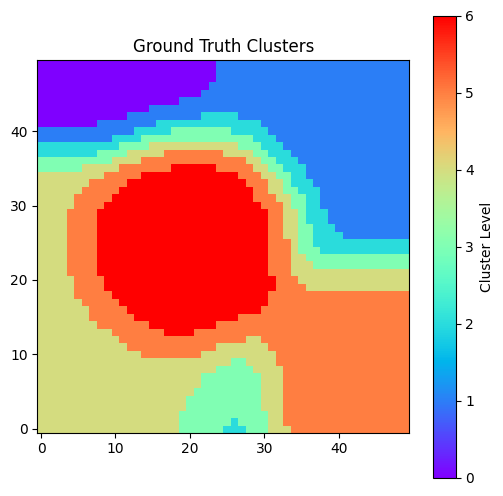

/tmp/ipykernel_94809/802197945.py:81: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  data[i] = np.sum(weights[k] * np.random.multivariate_normal(means[k], covariances[k], 1) for k in range(num_clusters))


In [3]:
# Set grid dimensions and random seed
np.random.seed(random_seed)

# Step 1: Initialize an empty grid and randomly assign cluster "patches"
ground_truth = np.zeros((grid_size, grid_size), dtype=int)
for cluster_id in range(1, num_clusters):
    # Randomly choose a center for each cluster
    center_x, center_y = np.random.randint(0, grid_size, size=2)
    radius = np.random.randint(10, 30)  # Random radius for each cluster region

    # Assign cluster_id to a circular region around the chosen center
    for i in range(grid_size):
        for j in range(grid_size):
            if (i - center_x) ** 2 + (j - center_y) ** 2 < radius ** 2:
                ground_truth[i, j] = cluster_id

# Step 2: Add random noise within each patch
noise_level = 0.5
noisy_grid = ground_truth + noise_level * np.random.randn(grid_size, grid_size)

# Step 3: Apply Gaussian smoothing to create spatial clustering
sigma = 3  # Controls the amount of clustering smoothness
smoothed_grid = scipy.ndimage.gaussian_filter(noisy_grid, sigma=sigma)

# Step 4: Threshold to obtain integer values
clustered_grid = np.round(smoothed_grid).astype(int)
clustered_grid = np.clip(clustered_grid, 0, num_clusters)

# Plot the clustered grid with flipped y axis
fig, ax = plt.subplots(figsize=(6, 6)) 
ax.imshow(clustered_grid, cmap="tab20", interpolation="nearest", origin='lower')  # Flip y axis by setting origin to 'lower'
ax.set_title("Ground Truth Clusters")
plt.colorbar(ax.imshow(clustered_grid, cmap="rainbow", interpolation="nearest", origin='lower'), ax=ax, label="Cluster Level", ticks=range(num_clusters + 1))  # Flip y axis by setting origin to 'lower'
os.makedirs("results/SYNTHETIC", exist_ok=True)
plt.savefig("results/SYNTHETIC/ground_truth.png")

plt.show()

def find_indices_within_distance(grid, r=1):
    indices_within_distance = np.empty((grid.shape[0], grid.shape[1]), dtype=object)
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            # Check all neighboring cells within a Manhattan distance of 1
            neighbors = []
            for x in range(max(0, i-r), min(grid.shape[0], i+r+1)):
                for y in range(max(0, j-r), min(grid.shape[1], j+r+1)):
                    if abs(x - i) + abs(y - j) <= r:
                        neighbors.append((x, y))
            indices_within_distance[i, j] = neighbors
    return indices_within_distance

# get the rook neighbors for each spot
indices = find_indices_within_distance(clustered_grid, r=r)

prior_weights = np.zeros((clustered_grid.shape[0] * clustered_grid.shape[1], num_clusters))

# for each spot sample 
for i in range(clustered_grid.shape[0]):
    for j in range(clustered_grid.shape[1]):
        for neighbor in indices[i, j]:
            prior_weights[i * clustered_grid.shape[1] + j, clustered_grid[neighbor]] += 1
prior_weights = prior_weights / prior_weights.sum(axis=1, keepdims=True)

# Initialize lists for means, covariances, and data points
means = []
covariances = []
data = np.empty((clustered_grid.shape[0] * clustered_grid.shape[1], data_dimension))

# Generate means and covariances for each cluster
for i in range(num_clusters):
    # Randomly set the mean close to the origin to encourage overlap
    mean = np.random.uniform(-5, 5, data_dimension)
    # Generate a diagonal covariance matrix with random magnitudes
    covariance = np.diag(np.random.rand(data_dimension) * 2.5)
    
    means.append(mean)
    covariances.append(covariance)
    
# Generate samples from the mixture.
for i, weights in enumerate(prior_weights):
    data[i] = np.sum(weights[k] * np.random.multivariate_normal(means[k], covariances[k], 1) for k in range(num_clusters))

# Create an anndata object
adata = ad.AnnData(data)

# Add row and col index
adata.obs['spot_number'] = np.arange(clustered_grid.shape[0] * clustered_grid.shape[1])
adata.obs['spot_number'] = adata.obs['spot_number'].astype('category')
adata.obs['row'] = np.repeat(np.arange(clustered_grid.shape[0]), clustered_grid.shape[1])
adata.obs['col'] = np.tile(np.arange(clustered_grid.shape[1]), clustered_grid.shape[0])
clustering = XeniumCluster(data=adata.X, dataset_name="SYNTHETIC")
clustering.xenium_spot_data = adata
clustering.num_clusters = num_clusters
clustering.data_dimension = data_dimension

# Xenium_to_BayesSpace(clustering.xenium_spot_data, dataset_name="SYNTHETIC", spot_size=grid_size)

In [4]:
[np.diag(cov) for cov in covariances]

[array([1.78573878, 0.73828492, 2.46600644, 2.11560433, 1.40100295]),
 array([0.27988861, 1.27818223, 1.59619489, 0.30553095, 0.8604909 ]),
 array([0.58891559, 1.5454546 , 0.7570713 , 0.22191927, 0.76315368]),
 array([0.8803884 , 2.27858785, 1.23874359, 2.18173181, 0.55132449]),
 array([1.16635873, 2.19807892, 0.67417567, 0.88704837, 0.80088573]),
 array([1.46774534, 0.13788021, 0.35214499, 0.24089638, 2.03028892]),
 array([1.57898441, 2.40915678, 1.49928591, 0.02379929, 1.03910251])]

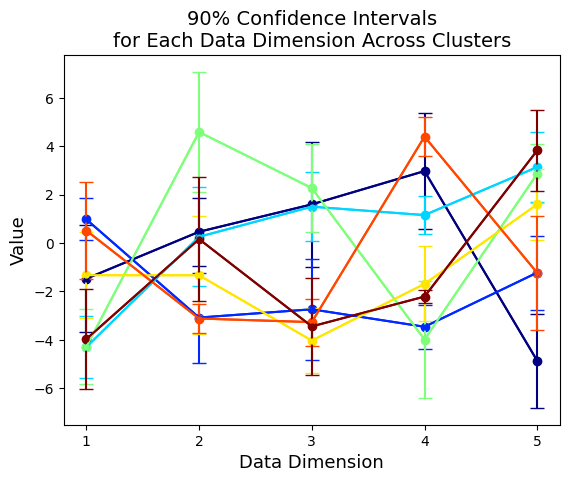

In [6]:
# Ensure colors don't cycle by specifying a color for each plot
colors = plt.get_cmap('jet')(np.linspace(0, 1, len(means)))
for i, (mean, cov) in enumerate(zip(means, [np.diag(cov) for cov in covariances])):
    plt.plot(np.arange(1, len(mean)+1), mean, marker=".", markersize=12, color=colors[i])
    plt.errorbar(np.arange(1, len(mean)+1), mean, yerr=1.645*np.sqrt(cov), marker=".", markersize=7, color=colors[i], capsize=5)

plt.xticks(np.arange(1, len(mean)+1, 1.0))  # Set x ticks to be integers from 1 to len(mean)
plt.title("90% Confidence Intervals\nfor Each Data Dimension Across Clusters", fontsize=14)
plt.xlabel("Data Dimension", fontsize=13)
plt.ylabel("Value", fontsize=13)
plt.savefig("conf.png", dpi=300)  # Save the image with high quality